## Import Libraries

In [36]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set up visualization and suppress warnings
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading & Inspection
## **Objective**: Load and understand the structure of NASA's turbofan degradation data
## - **train_FD001**: Training data with run-to-failure records
## - **test_FD001**: Test data without failure endpoints
## - **RUL_FD001**: True Remaining Useful Life (RUL) for test units
# - LOAD DATA

In [37]:
# Define column names based on dataset documentation
columns = ['unit_id', 'time_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + \
          [f'sensor_{i:02d}' for i in range(1, 22)]
# Load datasets
train_df = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=columns).dropna(axis=1)
test_df = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=columns).dropna(axis=1)
true_rul = pd.read_csv('RUL_FD001.txt', header=None, names=['true_rul'])



# ### Initial Data Inspection
# - Check data dimensions and basic statistics
# - Verify sensor readings and operational settings

In [38]:
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nTraining Data Summary:")
print(train_df.describe())


Training Data Shape: (20631, 26)
Test Data Shape: (13096, 26)

Training Data Summary:
            unit_id   time_cycles  op_setting_1  op_setting_2  op_setting_3  \
count  20631.000000  20631.000000  20631.000000  20631.000000       20631.0   
mean      51.506568    108.807862     -0.000009      0.000002         100.0   
std       29.227633     68.880990      0.002187      0.000293           0.0   
min        1.000000      1.000000     -0.008700     -0.000600         100.0   
25%       26.000000     52.000000     -0.001500     -0.000200         100.0   
50%       52.000000    104.000000      0.000000      0.000000         100.0   
75%       77.000000    156.000000      0.001500      0.000300         100.0   
max      100.000000    362.000000      0.008700      0.000600         100.0   

       sensor_01     sensor_02     sensor_03     sensor_04     sensor_05  ...  \
count   20631.00  20631.000000  20631.000000  20631.000000  2.063100e+04  ...   
mean      518.67    642.680934   1590.52

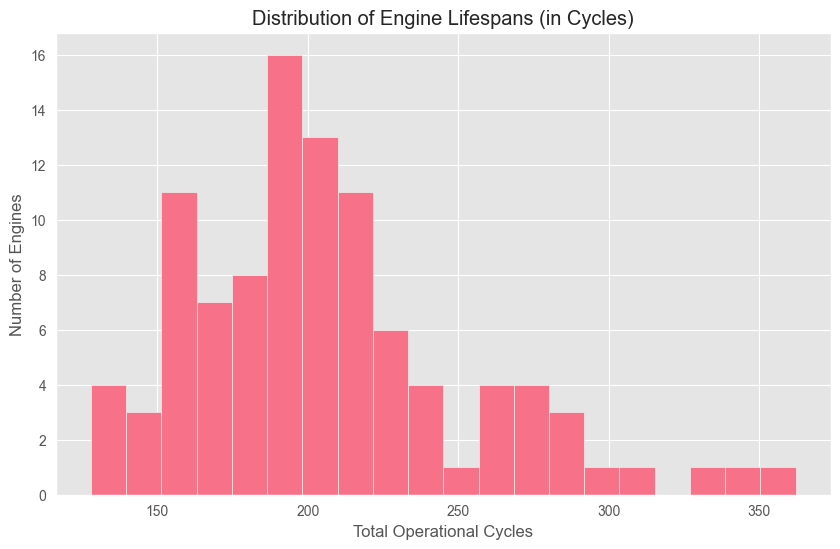

In [39]:
# Plot unit lifetime distribution
plt.figure(figsize=(10, 6))
train_df.groupby('unit_id')['time_cycles'].max().hist(bins=20)
plt.title('Distribution of Engine Lifespans (in Cycles)')
plt.xlabel('Total Operational Cycles')
plt.ylabel('Number of Engines')
plt.show()
# Explanation: This histogram shows how many operational cycles engines typically last before failure.

# ## 2. Data Preprocessing
## **Key Steps**:
## 1. Calculate RUL for training data
## 2. Handle sensor data variance
## 3. Normalize features
## 4. Prepare test data with true RUL


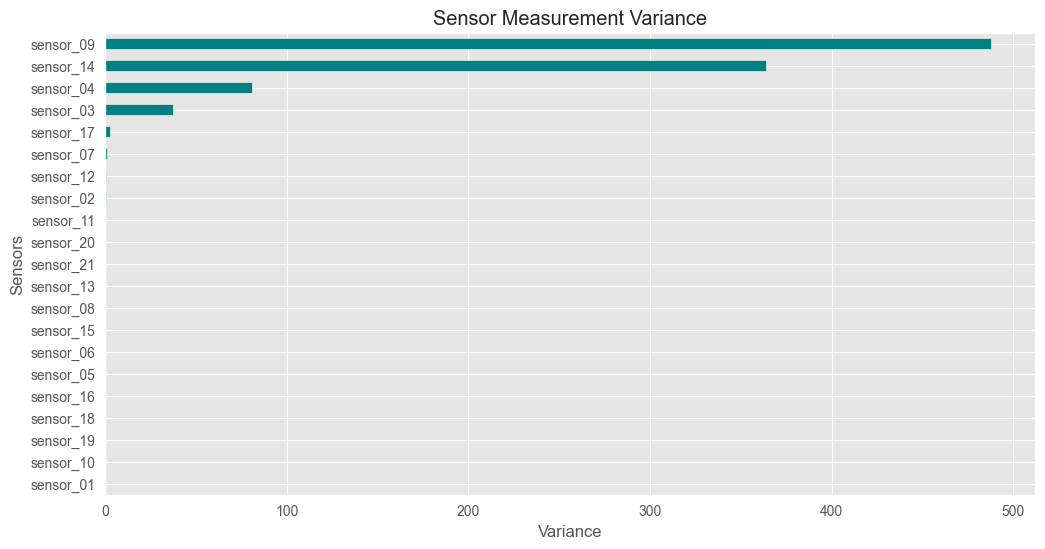

In [40]:
# Calculate maximum cycles for each unit
max_cycles = train_df.groupby('unit_id')['time_cycles'].max().reset_index()
max_cycles.columns = ['unit_id', 'max_cycle']

# Merge with training data and calculate RUL
train_df = train_df.merge(max_cycles, on='unit_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)

# Calculate sensor variances
sensor_cols = [col for col in train_df.columns if 'sensor' in col]
sensor_var = train_df[sensor_cols].var()

# Plot sensor variance
plt.figure(figsize=(12, 6))
sensor_var.sort_values().plot(kind='barh', color='teal')
plt.title('Sensor Measurement Variance')
plt.xlabel('Variance')
plt.ylabel('Sensors')
plt.show()
# Explanation: Low-variance sensors (left side) provide less information and can be removed

# Remove low-variance sensors
low_var_sensors = sensor_var[sensor_var < 0.1].index
train_df.drop(low_var_sensors, axis=1)
test_df.drop(low_var_sensors, axis=1)

# Select features for normalization
features_to_scale = [col for col in train_df.columns if col not in ['unit_id', 'RUL']]

# Initialize scaler and fit on training data
scaler = MinMaxScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
test_df[features_to_scale] = scaler.transform(test_df[features_to_scale])

# Get last recorded cycle for each test unit
test_last_cycles = test_df.groupby('unit_id').last().reset_index()

# Merge with true RUL values
test_last_cycles['true_rul'] = true_rul['true_rul']


# ## 3. Feature Analysis & Selection
## **Objective**: Identify most important features for RUL prediction

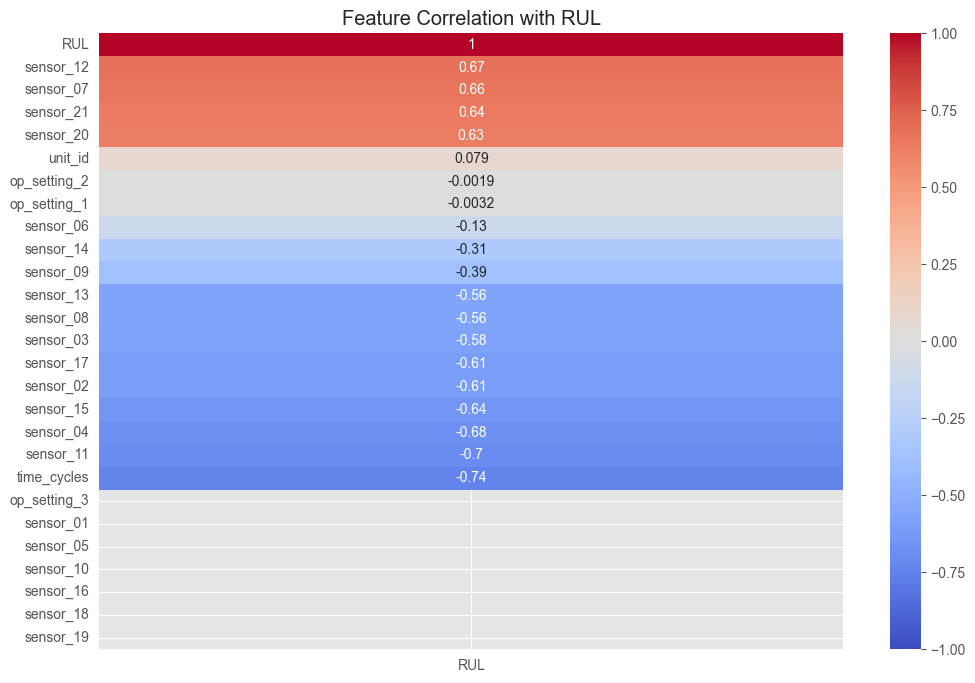

In [41]:
# Calculate feature correlations with RUL
corr_matrix = train_df.corr()
rul_correlations = corr_matrix['RUL'].sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['RUL']].sort_values(by='RUL', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with RUL')
plt.show()
# Explanation: Sensors showing strong correlation (positive/negative) with RUL are most important

# ## 4. Machine Learning Modeling
## **Approach**: Use Random Forest for RUL prediction

Validation MAE: 25.44
Validation R²: 0.72


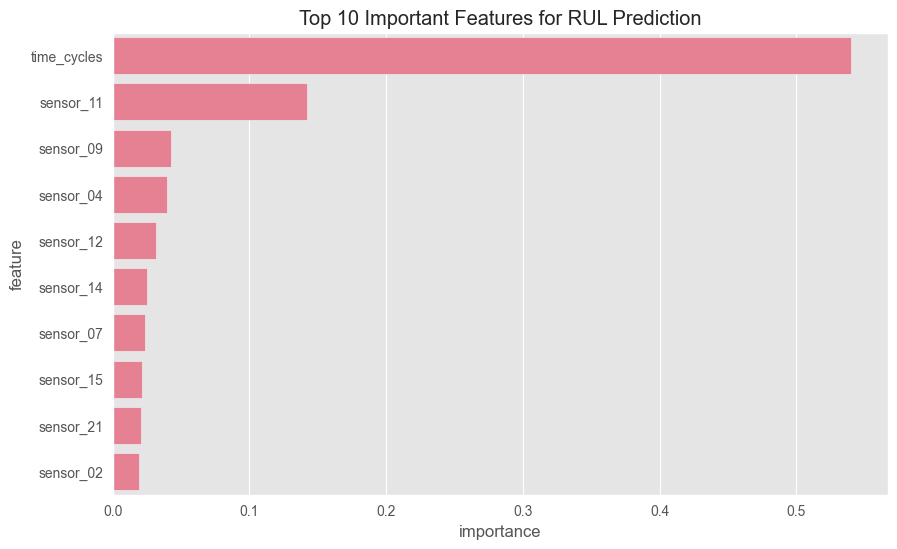

In [42]:
X = train_df.drop(['unit_id', 'RUL'], axis=1)
y = train_df['RUL']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate model
val_pred = rf_model.predict(X_val)
print(f"Validation MAE: {mean_absolute_error(y_val, val_pred):.2f}")
print(f"Validation R²: {r2_score(y_val, val_pred):.2f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Important Features for RUL Prediction')
plt.show()

# ## 5. Model Evaluation & Visualization


Test Set Performance:
MAE: 19.04
RMSE: 25.87
R²: 0.61


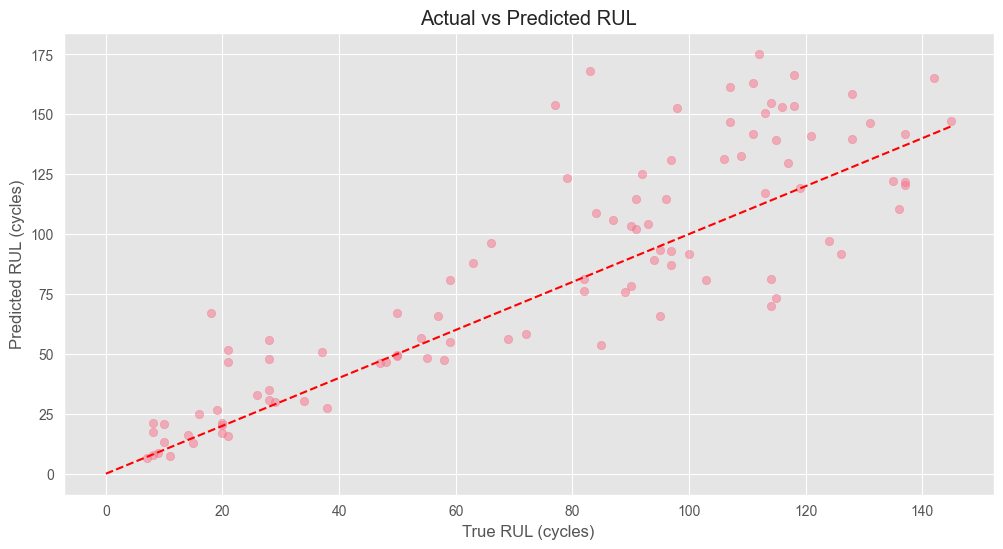

In [43]:
# Prepare test data
X_test = test_last_cycles.drop(['unit_id', 'true_rul'], axis=1)
y_test = test_last_cycles['true_rul']

# Make predictions
test_pred = rf_model.predict(X_test)

# Calculate metrics
print(f"\nTest Set Performance:")
print(f"MAE: {mean_absolute_error(y_test, test_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_pred)):.2f}")
print(f"R²: {r2_score(y_test, test_pred):.2f}")

plt.figure(figsize=(12, 6))
plt.scatter(y_test, test_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], 'r--')
plt.title('Actual vs Predicted RUL')
plt.xlabel('True RUL (cycles)')
plt.ylabel('Predicted RUL (cycles)')
plt.grid(True)
plt.show()
# Explanation: Points closer to the red line indicate better predictions

### Sensor Trend Analysis

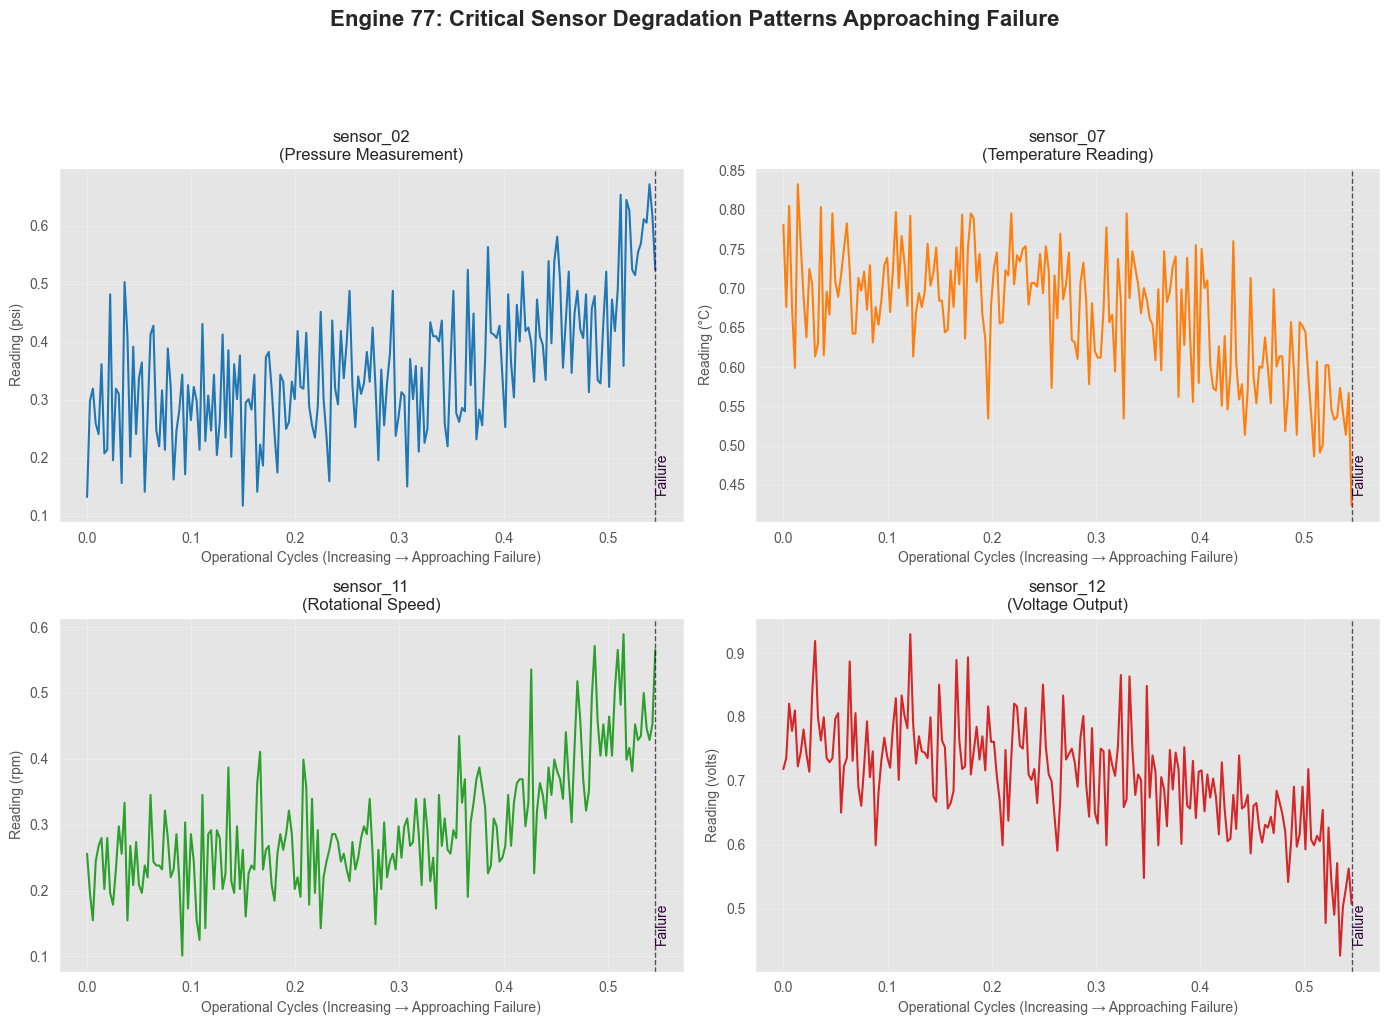

In [22]:
# Plot sensor trends for a sample engine

sample_engine = test_df[test_df['unit_id'] == 100]

# Create a figure with a 2x2 layout
plt.figure(figsize=(14, 10))
plt.suptitle('Engine 77: Critical Sensor Degradation Patterns Approaching Failure',
             y=1.02, fontsize=16, fontweight='bold')

sensor_config = {
    'sensor_02': {'color': '#1f77b4', 'unit': 'psi', 'description': 'Pressure Measurement'},
    'sensor_07': {'color': '#ff7f0e', 'unit': '°C', 'description': 'Temperature Reading'},
    'sensor_11': {'color': '#2ca02c', 'unit': 'rpm', 'description': 'Rotational Speed'},
    'sensor_12': {'color': '#d62728', 'unit': 'volts', 'description': 'Voltage Output'}
}

for i, sensor in enumerate(sensor_config.keys(), 1):
    ax = plt.subplot(2, 2, i)  # Update to a 2x2 grid layout
    sns.lineplot(x='time_cycles', y=sensor, data=sample_engine,
                 color=sensor_config[sensor]['color'], linewidth=1.5, ax=ax)

    # Find failure point (last operational cycle)
    failure_cycle = sample_engine['time_cycles'].max()

    # Add failure annotation
    ax.axvline(failure_cycle, color='#2c0032', linestyle='--', linewidth=1, alpha=0.7)

    # Dynamically place the "Failure" text close to the line
    y_position = sample_engine[sensor].min() + (sample_engine[sensor].max() - sample_engine[sensor].min()) * 0.1
    ax.text(failure_cycle, y_position, 'Failure',
            rotation=90, va='center', ha='left', color='#2c0032', fontsize=10)

    ax.set_title(f"{sensor}\n({sensor_config[sensor]['description']})", fontsize=12)
    ax.set_xlabel('Operational Cycles (Increasing → Approaching Failure)', fontsize=10)
    ax.set_ylabel(f"Reading ({sensor_config[sensor]['unit']})", fontsize=10)
    ax.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add padding for the main title
plt.show()

# Explanation: Shows how critical sensor measurements change as engines approach failure


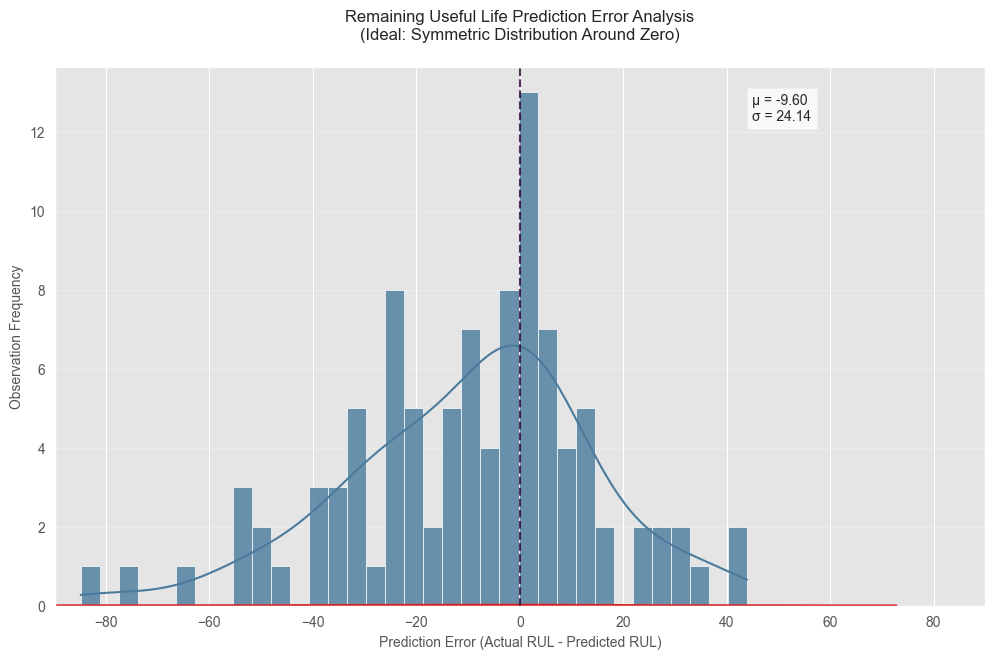

In [23]:
residuals = y_test - test_pred
plt.figure(figsize=(12, 7))
ax = sns.histplot(residuals, bins=35, kde=True,
                  color='#4a7b9d', edgecolor='white',
                  linewidth=0.5, alpha=0.8)
sns.kdeplot(residuals, color='#d62728', linewidth=2)

plt.title('Remaining Useful Life Prediction Error Analysis\n(Ideal: Symmetric Distribution Around Zero)',
          fontsize=12, pad=20)
plt.xlabel('Prediction Error (Actual RUL - Predicted RUL)', fontsize=10)
plt.ylabel('Observation Frequency', fontsize=10)
plt.axvline(0, color='#2c0032', linestyle='--', linewidth=1.5, alpha=0.8)

# Add distribution metrics
mean_resid = residuals.mean()
std_resid = residuals.std()
textstr = f'μ = {mean_resid:.2f}\nσ = {std_resid:.2f}'
ax.text(0.75, 0.95, textstr, transform=ax.transAxes,
        fontsize=10, verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8))

plt.grid(True, axis='y', alpha=0.3)
plt.xlim(-max(abs(residuals))-5, max(abs(residuals))+5)
plt.show()
# Explanation: Ideally, residuals should be normally distributed around zero

# 🛠️ Scheduled Maintenance Prediction

In [44]:
# 🛠️ Scheduled Maintenance Prediction
def predict_maintenance(model, test_data, threshold=30):
    """
    Predicts whether an engine needs maintenance based on its RUL prediction.

    Parameters:
    model       : Trained regression model (Random Forest or XGBoost)
    test_data   : DataFrame containing last known cycles for each engine
    threshold   : RUL threshold below which maintenance is needed (default = 30)

    Returns:
    DataFrame with predictions and maintenance status
    """

    # Select only necessary features for model prediction
    X_test = test_data.drop(columns=['true_rul', 'unit_id'], errors='ignore')

    # Make predictions using the trained model
    predicted_rul = model.predict(X_test)

    # Add predictions to the test_data DataFrame
    test_data = test_data.copy()  # Avoid modifying original DataFrame
    test_data['predicted_RUL'] = predicted_rul

    # Determine maintenance status based on the threshold
    test_data['maintenance_needed'] = test_data['predicted_RUL'] < threshold

    return test_data[['unit_id', 'predicted_RUL', 'maintenance_needed']]

# 🏭 Select the last known cycle of each engine for prediction
test_last_cycles = test_df.groupby('unit_id').last().reset_index()

# 📊 Predict maintenance status
maintenance_predictions = predict_maintenance(rf_model, test_last_cycles,80)

# 🔍 Display results
maintenance_predictions

,unit_id,predicted_RUL,maintenance_needed
0,1,175.28,False
1,2,152.71,False
2,3,56.28,True
3,4,81.24,False
4,5,102.21,False
...,...,...,...
95,96,141.61,False
96,97,76.31,True
97,98,80.88,False
98,99,129.53,False
